In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
import tensorflow as tf

%matplotlib inline
plt.style.use('seaborn-ticks')
sys.path.append("/home/vishal/Workspace/nn-ocr")

In [2]:
# From pkmital/pycadl.
import cadl
# From this repository.
import chars_vaegan
# From indraastra/nn-ocr.
from dataset import dataset, en
import fonts as font_utils

Using TensorFlow backend.


In [3]:
SIZE = 100

In [4]:
LABELS = en.get_labels()
FONTS = [font_utils.load_font(f) for f in en.get_fonts()]

def render_char(char, font, size=SIZE):
    np_img = np.asarray(font_utils.char_to_glyph(char, font, size), np.uint8)
    return np.tile(np.expand_dims(np_img, -1), 
                   (1, 1, 3))

def render_chars(chars, fonts, size=SIZE):
    return np.array([[render_char(char, font, size) for char in chars]
                     for font in fonts])

def show_images(imgs):
    plt.imshow(np.hstack(np.hstack(imgs)), cmap='gray')

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = chars_vaegan.load_vaegan("vaegan_model", sess)

def preprocess(img):
    img = imresize(img, (SIZE, SIZE))
    return img / 255.

def postprocess(recon):
    return (np.clip(recon / recon.max(), 0, 1) * 255).astype(np.uint8)

print(model.keys())

INFO:tensorflow:Restoring parameters from vaegan_model/vaegan-700
VAE model restored.
dict_keys(['loss_dis', 'x_tilde', 'loss_GAN', 'loss_enc', 'x', 'loss_samp', 'loss_real', 'gamma', 'z_samp', 'x_tilde_samp', 'loss_fake', 'z', 'loss_D_llike', 'loss_gen'])


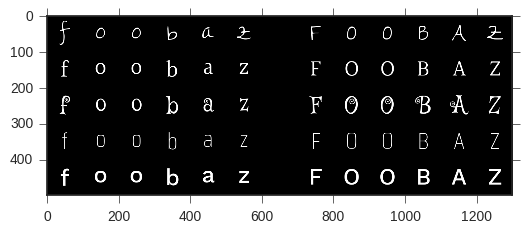

In [134]:
# Generate renderings of this text for 5 different fonts.
imgs = render_chars('foobaz FOOBAZ', random.sample(FONTS, 5))
show_images(imgs)

In [135]:
# Generate reconstructions of the above images.
imgs_xs = np.array([preprocess(img) for img in imgs.reshape((-1, SIZE, SIZE, 3))])
recon, zs = sess.run([model['x_tilde'], model['z']], 
                     feed_dict={model['x']: imgs_xs})
imgs_recon = np.array([postprocess(img) for img in recon]).reshape(imgs.shape)
imgs_zs = zs.reshape((imgs.shape[0], imgs.shape[1], -1))

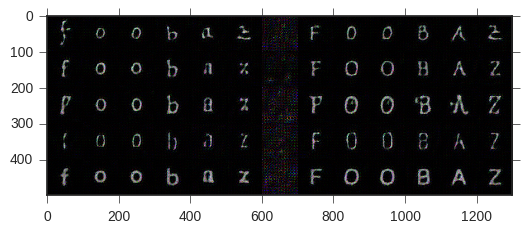

In [136]:
# Display reconstructions of the original text.
show_images(imgs_recon)

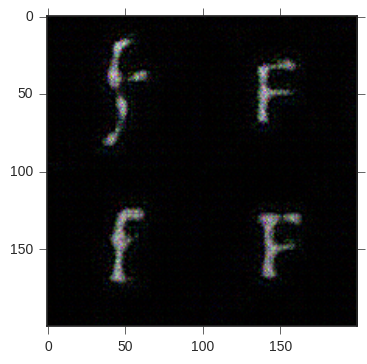

In [137]:
show_images([[imgs_recon[0, 0], imgs_recon[0, 7]],
             [imgs_recon[1, 0], imgs_recon[1, 7]]])

In [140]:
# CAPITALIZATION TRANSFER
# Let's try and reconstruct the capital letters by playing with the latent space.
# We do this by subtracting encodings for the lowercase letters from corresponding
# encodings of the uppercase letters, then averaging the result by letter. We add
# the averages back to the lowercase encodings and see what the result is after
# reconstruction below.
new_zs = (imgs_zs[0:, 7:] - imgs_zs[0:, 0:6]).mean(axis=0) + imgs_zs[0:, 0:6]

In [142]:
recon = sess.run(model['x_tilde'], 
                 feed_dict={model['z']: new_zs.reshape(-1, 64)})
new_recon = np.array([postprocess(img) for img in recon]).reshape((5, 6, SIZE, SIZE, 3))

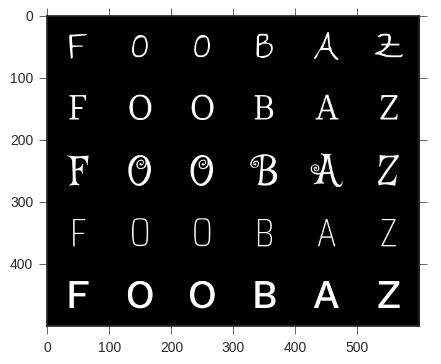

In [143]:
# ORIGINAL.
show_images(imgs[:, 7:])

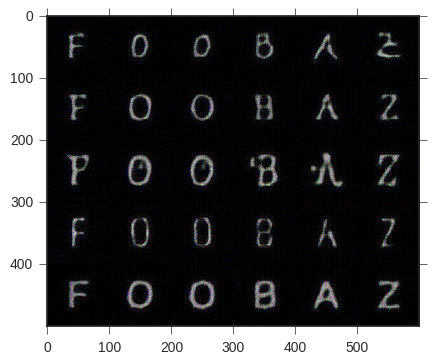

In [144]:
# RECONSTRUCTED FROM ENCODING.
show_images(imgs_recon[:, 7:])

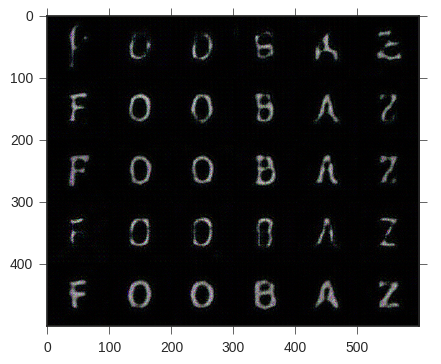

In [145]:
# RECONSTRUCTED FROM ENCODING MATH.
show_images(new_recon)

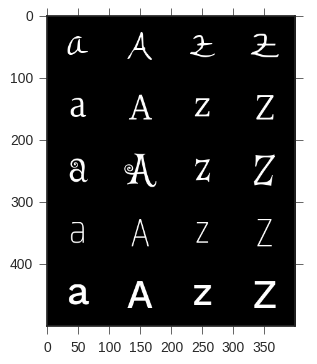

In [155]:
# LETTER TRANSFER
# Now, let's try to convert a in
az_imgs = imgs[:, [4, 11, 5, 12]]
az_imgs_recon = imgs_recon[:, [4, 11, 5, 12]]
az_imgs_zs = imgs_zs[:, [4, 11, 5, 12]]
show_images(az_imgs)

In [153]:
new_zs = (az_imgs_zs[:, 2:] - az_imgs_zs[:, :2]).mean(axis=0) + az_imgs_zs[:, :2]
recon = sess.run(model['x_tilde'], 
                 feed_dict={model['z']: new_zs.reshape(-1, 64)})
new_recon = np.array([postprocess(img) for img in recon]).reshape((5, 2, SIZE, SIZE, 3))

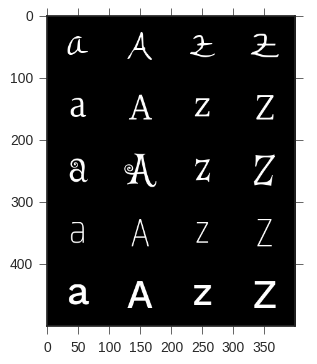

In [154]:
# ORIGINAL.
show_images(az_imgs)

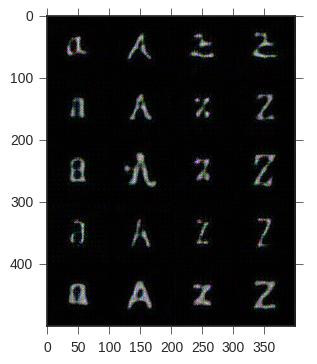

In [156]:
# RECONSTRUCTED FROM ENCODING.
show_images(az_imgs_recon)

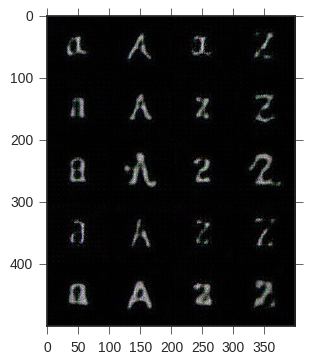

In [164]:
# RECONSTRUCTED FROM ENCODING MATH.
show_images(np.hstack([az_imgs_recon[:, :2], new_recon]))

In [11]:
zs = np.array([[0.52933282,0.68580389,0.20317066,0.47955635,0.61225468,0.45782363                                                                                          
,0.30801955,0.54645848,0.47542819,0.4338842,0.67065072,0.44026968                                                                                                  
,0.50986922,0.38389617,0.41859162,0.60075837,0.47368923,0.48484758                                                                                                 
,0.54667956,0.81879884,0.42038327,0.52937454,0.55995333,0.30161506                                                                                                 
,0.62787628,0.47233301,0.57800555,0.49723297,0.51487982,0.46751291                                                                                                 
,0.4758392,0.50187433,0.55834639,0.3737908,0.61269426,0.59646159                                                                                                   
,0.54403967,0.53422338,0.60851568,0.6358763,0.53140765,0.4967553                                                                                                   
,0.5224691,0.39083761,0.4573375,0.60490185,0.42250216,0.71883982                                                                                                   
,0.44297582,0.31363201,0.5322482,0.55384207,0.53225452,0.42375764                                                                                                  
,0.58682352,0.60221475,0.43768021,0.68214488,0.51805592,0.61545962                                                                                                 
,0.58400381,0.56097394,0.49883366,0.48213089],                                                                                                                     
[0.49058875,0.55454093,0.54478639,0.42890078,0.5278095,0.41011077                                                                                                 
,0.48935428,0.4752948,0.52049184,0.46671116,0.7146228,0.41531008                                                                                                   
,0.50893056,0.63452339,0.5827176,0.65099186,0.47164816,0.47602677                                                                                                  
,0.41579029,0.60379612,0.47927111,0.61846459,0.4204883,0.4424808                                                                                                   
,0.4972893,0.40448251,0.49866825,0.58194202,0.60256177,0.53894138                                                                                                  
,0.44355637,0.36610043,0.5051294,0.59559417,0.45025563,0.53734058                                                                                                  
,0.43616766,0.50947577,0.53820151,0.5159992,0.56873488,0.46596909                                                                                                  
,0.62133241,0.57547909,0.39367345,0.42855173,0.53735268,0.41480815                                                                                                 
,0.53907263,0.5699839,0.26326594,0.2972959,0.51335186,0.43872488                                                                                                   
,0.53390199,0.53540307,0.44282162,0.51100022,0.49208397,0.5149529                                                                                                  
,0.62156171,0.59524679,0.47730863,0.62824845],                                                                                                                     
[0.52933282,0.68580389,0.20317066,0.47955635,0.61225468,0.45782363                                                                                          
,0.52171111,0.32070637,0.37904269,0.36856544,0.44176856,0.29609746                                                                                                 
,0.47465202,0.31726113,0.32386649,0.25114447,0.50643563,0.36572564                                                                                                 
,0.45217586,0.39447135,0.43043798,0.55340707,0.47421718,0.42202222                                                                                                 
,0.36174679,0.391886,0.37026426,0.45329449,0.39298996,0.35463494                                                                                                   
,0.38375336,0.43953604,0.40499741,0.54716599,0.35699683,0.39487049                                                                                                 
,0.36373085,0.39519352,0.46847251,0.43596572,0.4165335,0.43615443                                                                                                  
,0.50930297,0.37907961,0.38816175,0.39742899,0.35827398,0.44280979                                                                                                 
,0.45896709,0.33370101,0.39810747,0.3182078,0.30305749,0.46271458                                                                                                  
,0.43861049,0.44202793,0.46068993,0.39876276,0.38177836,0.35217842                                                                                                 
,0.41925472,0.38341272,0.51943201,0.61730945],                                                                                                                     
[0.38608164,0.32984579,0.54628664,0.42974031,0.3796134,0.25702441                                                                                                 
,0.50041795,0.30693981,0.36525893,0.35425419,0.42395651,0.28476521                                                                                                 
,0.45702538,0.30400836,0.3115446,0.23832673,0.48773146,0.35206091                                                                                                  
,0.43421435,0.37916481,0.41531527,0.53534675,0.4574216,0.40486455                                                                                                  
,0.34750468,0.37217548,0.35414824,0.43755105,0.38038337,0.33984634                                                                                                 
,0.36925739,0.42221999,0.39020851,0.52670765,0.34422231,0.37855005                                                                                                 
,0.35149497,0.37850058,0.45146823,0.41670603,0.39902356,0.42321146                                                                                                 
,0.48844808,0.36078194,0.37342533,0.38109839,0.34397554,0.42628115                                                                                                 
,0.44321227,0.31760591,0.38493297,0.30664018,0.29150382,0.44414979                                                                                                 
,0.42255425,0.42510119,0.44382676,0.38373503,0.36795491,0.33969712                                                                                                 
,0.403045,0.36894882,0.50045758,0.59352052]])

In [12]:
zs = (zs - 0.5) * 10

In [13]:
recon = sess.run(model['x_tilde'], 
                 feed_dict={model['z']: zs.reshape(-1, 64)})
recon = np.array([postprocess(img) for img in recon]).reshape((2, 2, SIZE, SIZE, 3))

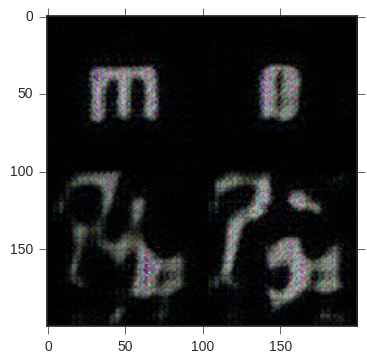

In [14]:
show_images(recon)